In [190]:
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

# matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

In [191]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [192]:
df = pd.read_csv('/content/drive/MyDrive/PSV-proiect/df_features.csv')
print(df.shape)
df.head()

(999, 98)


,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_3_std,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std
0,rock/rock.00000.wav,0.102,0.148,1.922,2.865,0.090,0.040,0.129,0.072,123.047,...,0.325,0.243,0.336,0.284,0.238,0.296,0.261,0.348,0.235,0.225
1,rock/rock.00001.wav,0.145,0.194,1.422,1.065,0.055,0.029,0.180,0.070,151.999,...,0.325,0.247,0.359,0.241,0.273,0.270,0.294,0.363,0.286,0.283
2,rock/rock.00003.wav,0.120,0.164,1.944,2.436,0.043,0.031,0.151,0.063,95.703,...,0.242,0.262,0.334,0.344,0.292,0.295,0.332,0.362,0.275,0.234
3,rock/rock.00002.wav,0.110,0.169,2.573,5.575,0.077,0.048,0.149,0.081,107.666,...,0.310,0.179,0.219,0.237,0.221,0.228,0.255,0.304,0.280,0.342
4,rock/rock.00012.wav,0.058,0.084,2.680,5.321,0.068,0.057,0.076,0.036,112.347,...,0.323,0.265,0.311,0.243,0.329,0.236,0.333,0.340,0.313,0.341


In [193]:
df['file_name'] = df['file_name'].apply(lambda x: x.split('/')[-1])
df.head()

,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_3_std,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std
0,rock.00000.wav,0.102,0.148,1.922,2.865,0.090,0.040,0.129,0.072,123.047,...,0.325,0.243,0.336,0.284,0.238,0.296,0.261,0.348,0.235,0.225
1,rock.00001.wav,0.145,0.194,1.422,1.065,0.055,0.029,0.180,0.070,151.999,...,0.325,0.247,0.359,0.241,0.273,0.270,0.294,0.363,0.286,0.283
2,rock.00003.wav,0.120,0.164,1.944,2.436,0.043,0.031,0.151,0.063,95.703,...,0.242,0.262,0.334,0.344,0.292,0.295,0.332,0.362,0.275,0.234
3,rock.00002.wav,0.110,0.169,2.573,5.575,0.077,0.048,0.149,0.081,107.666,...,0.310,0.179,0.219,0.237,0.221,0.228,0.255,0.304,0.280,0.342
4,rock.00012.wav,0.058,0.084,2.680,5.321,0.068,0.057,0.076,0.036,112.347,...,0.323,0.265,0.311,0.243,0.329,0.236,0.333,0.340,0.313,0.341


In [194]:
label_dict = {'rock': 0, 
              'reggae': 1,
              'pop': 2,
              'metal': 3,
              'jazz': 4,
              'hiphop': 5,
              'country': 6,
              'blues': 7,
              'disco': 8,
              'classical': 9}

scalar = MinMaxScaler()
df[df.columns[1:]] = scalar.fit_transform(df[df.columns[1:]])
df['label'] = df['file_name'].apply(lambda x: label_dict[x[:-10]])
df.head()

,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std,label
0,rock.00000.wav,0.305296,0.350877,0.305347,0.134336,0.269841,0.203704,0.315522,0.426829,0.463772,...,0.490741,0.726154,0.601190,0.462295,0.644231,0.526163,0.680982,0.434650,0.370717,0
1,rock.00001.wav,0.439252,0.466165,0.191581,0.065110,0.130952,0.135802,0.445293,0.414634,0.716115,...,0.503086,0.796923,0.473214,0.577049,0.560897,0.622093,0.726994,0.589666,0.551402,0
2,rock.00003.wav,0.361371,0.390977,0.310353,0.117837,0.083333,0.148148,0.371501,0.371951,0.225445,...,0.549383,0.720000,0.779762,0.639344,0.641026,0.732558,0.723926,0.556231,0.398754,0
3,rock.00002.wav,0.330218,0.403509,0.453470,0.238559,0.218254,0.253086,0.366412,0.481707,0.329713,...,0.293210,0.366154,0.461310,0.406557,0.426282,0.508721,0.546012,0.571429,0.735202,0
4,rock.00012.wav,0.168224,0.190476,0.477816,0.228790,0.182540,0.308642,0.180662,0.207317,0.370512,...,0.558642,0.649231,0.479167,0.760656,0.451923,0.735465,0.656442,0.671733,0.732087,0


In [195]:
df['file_name'] = df['file_name'].str.split('.')

# Reformatting the file_name column
df['file_name'] = df['file_name'].apply(lambda x: '.'.join([x[1], x[0], x[2]]))

# Displaying the updated DataFrame
print(df)

               file_name  signal_mean  signal_std  signal_skew  \
0         00000.rock.wav     0.305296    0.350877     0.305347   
1         00001.rock.wav     0.439252    0.466165     0.191581   
2         00003.rock.wav     0.361371    0.390977     0.310353   
3         00002.rock.wav     0.330218    0.403509     0.453470   
4         00012.rock.wav     0.168224    0.190476     0.477816   
5         00007.rock.wav     0.373832    0.401003     0.272355   
6         00008.rock.wav     0.644860    0.639098     0.073948   
7         00014.rock.wav     0.118380    0.137845     0.389306   
8         00013.rock.wav     0.320872    0.333333     0.223208   
9         00004.rock.wav     0.514019    0.513784     0.123549   
10        00011.rock.wav     0.295950    0.298246     0.176109   
11        00005.rock.wav     0.495327    0.508772     0.170193   
12        00006.rock.wav     0.426791    0.456140     0.212287   
13        00010.rock.wav     0.361371    0.385965     0.310125   
14        

In [196]:
df['file_name'] = df['file_name'].str.split('.')

# Reformatting the file_name column
df['file_name'] = df['file_name'].apply(lambda x: '_'.join([x[0], x[1] + '.' + x[2]]))

# Displaying the updated DataFrame
print(df)

               file_name  signal_mean  signal_std  signal_skew  \
0         00000_rock.wav     0.305296    0.350877     0.305347   
1         00001_rock.wav     0.439252    0.466165     0.191581   
2         00003_rock.wav     0.361371    0.390977     0.310353   
3         00002_rock.wav     0.330218    0.403509     0.453470   
4         00012_rock.wav     0.168224    0.190476     0.477816   
5         00007_rock.wav     0.373832    0.401003     0.272355   
6         00008_rock.wav     0.644860    0.639098     0.073948   
7         00014_rock.wav     0.118380    0.137845     0.389306   
8         00013_rock.wav     0.320872    0.333333     0.223208   
9         00004_rock.wav     0.514019    0.513784     0.123549   
10        00011_rock.wav     0.295950    0.298246     0.176109   
11        00005_rock.wav     0.495327    0.508772     0.170193   
12        00006_rock.wav     0.426791    0.456140     0.212287   
13        00010_rock.wav     0.361371    0.385965     0.310125   
14        

In [197]:
df.head()

,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std,label
0,00000_rock.wav,0.305296,0.350877,0.305347,0.134336,0.269841,0.203704,0.315522,0.426829,0.463772,...,0.490741,0.726154,0.601190,0.462295,0.644231,0.526163,0.680982,0.434650,0.370717,0
1,00001_rock.wav,0.439252,0.466165,0.191581,0.065110,0.130952,0.135802,0.445293,0.414634,0.716115,...,0.503086,0.796923,0.473214,0.577049,0.560897,0.622093,0.726994,0.589666,0.551402,0
2,00003_rock.wav,0.361371,0.390977,0.310353,0.117837,0.083333,0.148148,0.371501,0.371951,0.225445,...,0.549383,0.720000,0.779762,0.639344,0.641026,0.732558,0.723926,0.556231,0.398754,0
3,00002_rock.wav,0.330218,0.403509,0.453470,0.238559,0.218254,0.253086,0.366412,0.481707,0.329713,...,0.293210,0.366154,0.461310,0.406557,0.426282,0.508721,0.546012,0.571429,0.735202,0
4,00012_rock.wav,0.168224,0.190476,0.477816,0.228790,0.182540,0.308642,0.180662,0.207317,0.370512,...,0.558642,0.649231,0.479167,0.760656,0.451923,0.735465,0.656442,0.671733,0.732087,0


In [198]:
import os

with open('/content/drive/MyDrive/PSV-proiect/pred_probas/testset_filenames.txt', 'r') as f:
    test_files = f.readlines()
test_files = [t.strip() for t in test_files]

indices = []
for t in test_files:
    indices.append(df[df.file_name==t].index[0])
    
df_test = df.iloc[indices,:]
df.drop(labels=indices, inplace=True)

cl_weight = dict(pd.Series(df['label']).value_counts(normalize=True))

x_train = df[df.columns[1:-1]]
x_test = df_test[df.columns[1:-1]]
y_train = df['label']
y_test = df_test['label']

In [199]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(label_dict))
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=label_dict.keys())

### Logistic Regression
LR is usually done for binary classification tasks. For this multi-class classification task, the LR is implemented as a one-vs-rest method. That is, 10 separate classifiers are trained. During test time, the class with the highest prob. from among the 10 classifiers is the predicted class.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Set Accuracy =  0.68
Test Set F-score =  0.69
ROC AUC = 0.940
Confusion matrix, without normalization
[[11  2  1  3  0  0  5  2  3  0]
 [ 1  8  1  1  0  3  3  0  0  1]
 [ 0  0 17  0  0  1  1  0  0  0]
 [ 0  0  0 18  0  0  0  1  1  0]
 [ 0  0  0  0 18  0  0  1  0  1]
 [ 0  2  1  0  0 12  1  0  0  0]
 [ 1  1  2  0  0  0 15  5  0  0]
 [ 2  3  0  1  0  0  2 17  0  0]
 [ 2  1  1  0  1  1  1  1  9  0]
 [ 1  1  0  0  0  0  1  0  0 11]]
CPU times: user 582 ms, sys: 213 ms, total: 795 ms
Wall time: 1.24 s


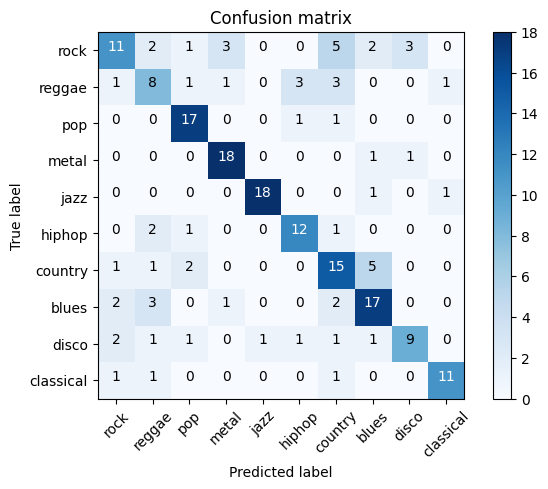

In [212]:
%%time
# Train
lr_classifier = LogisticRegression(penalty='l2')
lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)
# Save
with open('/content/drive/MyDrive/PSV-proiect/pred_probas/lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Random Forest

Test Set Accuracy =  0.70
Test Set F-score =  0.71
ROC AUC = 0.950
Confusion matrix, without normalization
[[12  2  0  1  1  1  5  0  5  0]
 [ 2 11  1  0  0  2  2  0  0  0]
 [ 0  0 14  0  0  2  1  0  2  0]
 [ 0  0  0 18  0  0  0  1  1  0]
 [ 0  0  0  0 18  0  0  1  0  1]
 [ 0  3  1  1  0 10  1  0  0  0]
 [ 2  0  2  0  0  0 18  2  0  0]
 [ 1  1  0  0  0  0  4 19  0  0]
 [ 4  0  1  0  0  0  1  0 10  1]
 [ 0  1  0  0  2  0  0  0  0 11]]
CPU times: user 3.65 s, sys: 48.2 ms, total: 3.7 s
Wall time: 3.71 s


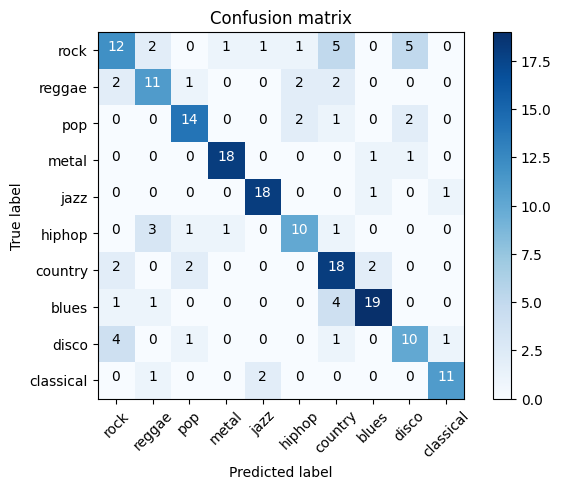

In [213]:
%%time
# Train
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('/content/drive/MyDrive/PSV-proiect/pred_probas/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Gradient Boosting 

Test Set Accuracy =  0.72
Test Set F-score =  0.72
ROC AUC = 0.952
Confusion matrix, without normalization
[[ 9  2  1  2  3  0  3  2  5  0]
 [ 2 13  0  1  0  0  1  0  1  0]
 [ 0  0 16  1  0  1  1  0  0  0]
 [ 0  0  0 18  0  0  0  1  1  0]
 [ 0  0  0  0 16  0  0  2  0  2]
 [ 1  2  0  1  0  9  1  1  1  0]
 [ 3  0  1  0  0  0 17  3  0  0]
 [ 1  1  0  0  0  0  1 22  0  0]
 [ 2  0  1  0  1  0  1  0 11  1]
 [ 0  0  0  0  1  0  0  0  0 13]]


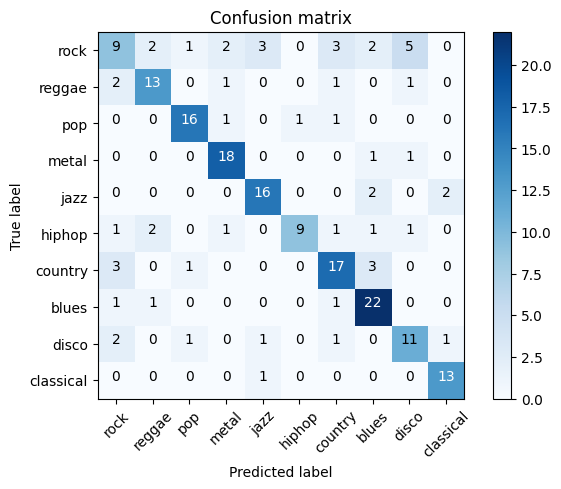

In [214]:
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, num_class = len(label_dict))
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)


# Save
with open('/content/drive/MyDrive/PSV-proiect/pred_probas/xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Support Vector Machines

Test Set Accuracy =  0.70
Test Set F-score =  0.70
ROC AUC = 0.956
Confusion matrix, without normalization
[[11  2  0  2  0  0  6  2  3  1]
 [ 2  9  2  0  0  3  2  0  0  0]
 [ 0  1 15  0  0  1  1  0  1  0]
 [ 0  0  0 18  0  0  0  1  1  0]
 [ 0  0  0  0 17  0  0  1  0  2]
 [ 0  3  0  1  0 12  0  0  0  0]
 [ 1  0  1  0  0  0 20  2  0  0]
 [ 3  1  0  0  0  0  1 20  0  0]
 [ 4  0  2  0  1  2  1  0  7  0]
 [ 0  2  0  0  0  0  0  0  0 12]]
CPU times: user 741 ms, sys: 31.1 ms, total: 772 ms
Wall time: 755 ms


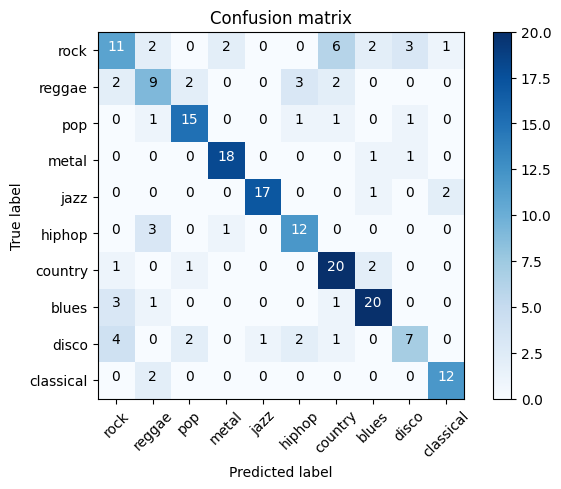

In [203]:
%%time
# Train
svm_classifier = SVC(C=10.0, probability = True, class_weight=cl_weight, kernel='rbf')
svm_classifier.fit(x_train, y_train)

# Predict
pred_probs = svm_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('/content/drive/MyDrive/PSV-proiect/pred_probas/svm_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Most Important Feature
Determine the features that contribute the most towards making the correct classfication

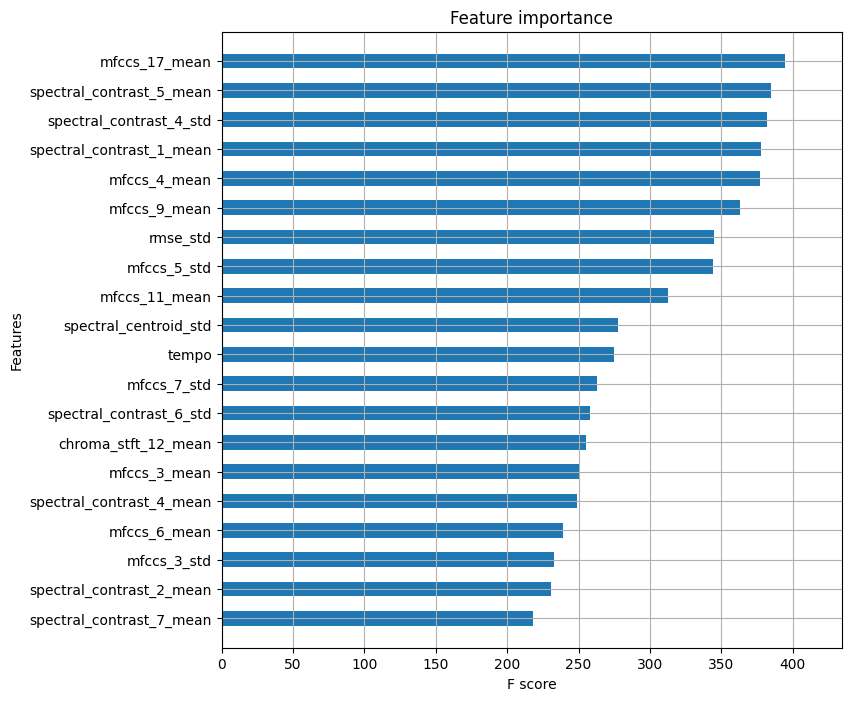

In [204]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=20, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)
# plt.savefig('plots/feature-imp.png', bbox_inches='tight')

The most important features seem to be MFCCs and spectral contrast (mean and std dev in different frequency bins). Use the top N features, build the model and look at the metrics

In [205]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.03339284, 0.05070308, 0.01243798, 0.00821211, 0.01212628,
       0.00362281, 0.03287797, 0.00874064, 0.01254662, 0.00623684,
       0.01623799, 0.02132291, 0.01704188, 0.06426971, 0.00640043,
       0.        , 0.        , 0.01162891, 0.00477895, 0.01804353,
       0.0291071 , 0.03660432, 0.00669851, 0.02084169, 0.00453891,
       0.00877709, 0.00875256, 0.00982855, 0.0400172 , 0.00303255,
       0.00471581, 0.02287014, 0.0107016 , 0.00631136, 0.00808273,
       0.01013872, 0.01076514, 0.00434593, 0.00400074, 0.01005662,
       0.00752324, 0.0074432 , 0.00214101, 0.00698894, 0.01316447,
       0.00845786, 0.0044022 , 0.00871314, 0.00775148, 0.00468069,
       0.00565534, 0.00782751, 0.00668284, 0.00549754, 0.00463377,
       0.00599437, 0.00920845, 0.01096409, 0.01655506, 0.01498374,
       0.00846859, 0.00905642, 0.00756593, 0.00628965, 0.01224982,
       0.00943357, 0.00485941, 0.00222628, 0.00467159, 0.00491196,
       0.00517526, 0.0110417 , 0.00774697, 0.00512609, 0.00455

### Ensemble of XGB and VGG

Test Set Accuracy =  0.78
Test Set F-score =  0.78
ROC AUC = 0.967
Confusion matrix, without normalization
[[13  2  0  1  2  0  1  3  3  0]
 [ 2 13  1  1  0  0  1  0  0  0]
 [ 0  0 16  0  0  1  1  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  0  1  0  1]
 [ 0  3  0  1  0  9  1  1  0  0]
 [ 2  0  1  0  0  0 17  2  0  0]
 [ 1  1  0  0  0  0  1 21  0  0]
 [ 2  0  1  0  1  0  1  0 11  1]
 [ 0  0  0  0  1  0  0  0  0 13]]


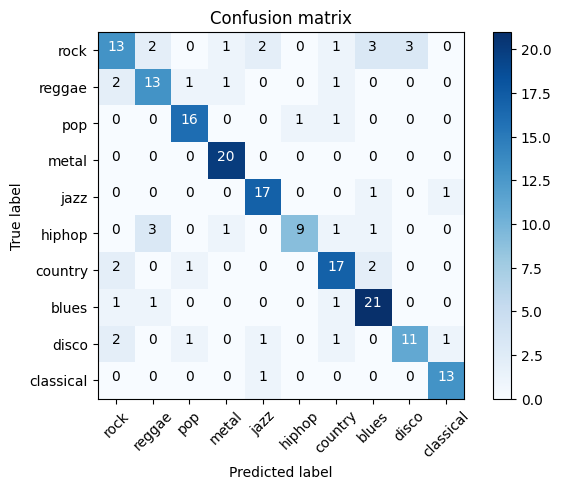

In [216]:
# Load predicted probabilities
with open('/content/drive/MyDrive/PSV-proiect/pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('/content/drive/MyDrive/PSV-proiect/pred_probas/vgg_transfer_learning.pkl', 'rb') as f:
    vgg_pred_probs = pickle.load(f)
    
n_samples = np.min([len(xgb_pred_probs), len(vgg_pred_probs)])

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs[:n_samples] + vgg_pred_probs[:n_samples])/2.0

# Show metrics
display_results(y_test[:n_samples], ensemble_pred_probs)

### Plot 3 ROCs the same graph
- VGG
- XGB
- Ensemble

In [217]:
# Compute macro-average ROC curve and ROC area
# Compute ROC curve and ROC area for each class

def plot_roc_curves(y_true, pred_probs, label_dict):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    NUM_CLASSES = len(label_dict)
    one_hot_true = one_hot_encoder(y_true, len(y_true), NUM_CLASSES)
    for i in range(len(label_dict)):
        fpr[i], tpr[i], _ = roc_curve(one_hot_true[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= NUM_CLASSES

    return all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

<ipython-input-217-881e2a09a1aa>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])
<ipython-input-217-881e2a09a1aa>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])
<ipython-input-217-881e2a09a1aa>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


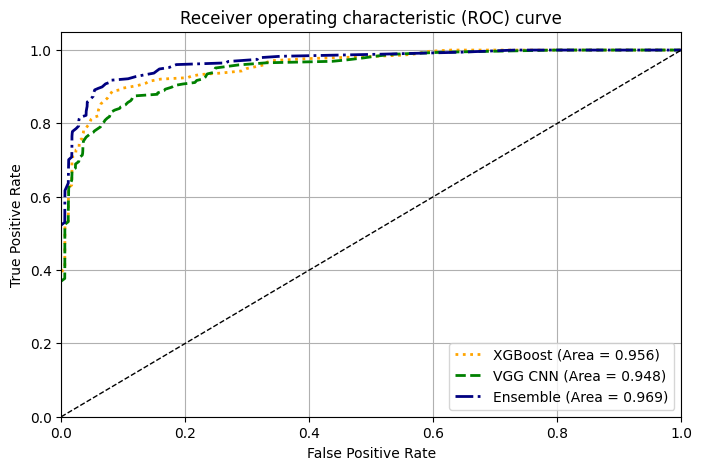

In [220]:
# Plot all ROC curves
plt.figure(figsize=(8,5))

plt.title('Macro-average ROC curves')

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], xgb_pred_probs[:n_samples], label_dict)
plt.plot(fpr, tpr,
         label='XGBoost (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='orange', linestyle=':', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], vgg_pred_probs[:n_samples], label_dict)
plt.plot(fpr, tpr,
         label='VGG CNN (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='green', linestyle='--', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], ensemble_pred_probs[:n_samples]
                                    , label_dict)
plt.plot(fpr, tpr,
         label='Ensemble (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='navy', linestyle='-.', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
# plt.savefig('plots/roc-curve.png')
plt.show()